<a href="https://colab.research.google.com/github/rafabrnd/Coursera_Capstone/blob/master/coursera_capstone_bar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Finding the best location for a nightclub in the city of Copenhagen, Denmark

A multinational nightlife investment company who owns diverse bars and nightclubs would like to expand his business to the city of Copenhagen in Denmark. Diverse previous reports indicated that the most lively areas (areas where most bars & nightclubs) are located have the most amount of food traffic in the city during the night time. For this reason, the company would like to find areas of the city that are arealy established as go-to zones for the young party community. These areas would represent the perfect location for a new and exciting nightlife business. 

In this notebook I will cluster the different locations of the city of Copenhagen based on the most common venues in order to understand where the location of the new bar should be. 

Import necessary libraries

In [205]:
#basics
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation

# libraries for displaying images // HTML extractors
#!pip install beautifulsoup4
#!pip install lxml
from IPython.display import Image 
from IPython.core.display import HTML 
from IPython.display import display_html
from bs4 import BeautifulSoup

# tranforming json file into a pandas dataframe library
import json # library to handle JSON files
from pandas.io.json import json_normalize


#maps
#!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values
from geopy.exc import GeocoderTimedOut

#machine learning
from sklearn.cluster import KMeans

#visualizations
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

print('Libraries imported.')

Libraries imported.


# 1. Extract the data & Wrangling
More information on this package here: 


*   http://beautiful-soup-4.readthedocs.io/en/latest/

*   https://www.youtube.com/watch?v=ng2o98k983k

In [206]:
source = requests.get('https://www.regionh.dk/english/about-the-capital-region/facts-about-the-region/Pages/Postal-codes.aspx').text
soup=BeautifulSoup(source,'lxml')
from IPython.display import display_html
tab = str(soup.table)
display_html(tab,raw=True)

City,Postal codes
Albertslund,2620
Allerød,3450
Allinge,3770
Bagsværd,2880
Ballerup,2750
Birkerød,3460
Brøndby,2605
Brøndby Strand,2660
Brønshøj,2700
Charlottenlund,2920


Convert the table to a Pandas DataFrame

In [207]:
#accomodation of the correct decimal places
pd.options.display.float_format = "{:,.8f}".format

#set max with of the columns to accomodate long names
pd.set_option('display.max_colwidth', 0)

#converts into a dataframe; its like an array now 
cph = pd.read_html(tab)
cph = cph[0]

#rename the columns 
cph.columns = ['Neighborhood', 'Postal Codes']
cph = cph.drop(index = 0 )
cph = cph.reset_index(drop=True)

cph.head()

print('Shape of the dataframe is: ', cph.shape)

,Neighborhood,Postal Codes
0,Albertslund,2620
1,Allerød,3450
2,Allinge,3770
3,Bagsværd,2880
4,Ballerup,2750


There are 3 situations where the Postal Codes are not displayed. This is because in those Neighborhoods individual streets have different postal codes. However, after some research on the subject I found that there is in fact a unique postal code that identify each of these neighborhoods. These postal codes are: 

Frederiksberg C: 1874
København K: 1050
København V: 1653

Since they are only 3 situations where this occured, I decided to change them manually

In [209]:
cph.loc[16,'Postal Codes'] = 1874
cph.loc[48,'Postal Codes'] = 1050
cph.loc[54,'Postal Codes'] = 1653
print (cph.loc[16])
print (cph.loc[48])
print (cph.loc[54])

Neighborhood    Frederiksberg C
Postal Codes    1874           
Name: 16, dtype: object
Neighborhood    København K
Postal Codes    1050       
Name: 48, dtype: object
Neighborhood    København V
Postal Codes    1653       
Name: 54, dtype: object


From the current DataFrame we have values for all the neighborhoods in the whole island (or province). Most of those locations are irrelevant for our business problem as they are not located anywhere near the city. Therefore I filtered the neighborhoods that contain 'København' in their name which are the ones that we are interested in as they are the neighborhoods in the city. 
Also, I manually added a few other neighborhoods that are in close proximity to the filtered neighborhoods which could be areas of interest. 

In [210]:
selected = ['København','Frederiksberg', 'Brønshøj','Valby','Vanløse','Hellerup','Hvidovre','Dyssegård']
cph = cph[cph['Neighborhood'].str.contains('|'.join(selected))]
cph.head()

,Neighborhood,Postal Codes
8,Brønshøj,2700
12,Dyssegård,2870
16,Frederiksberg C,1874
17,Frederiksberg,2000
29,Hellerup,2900
38,Hvidovre,2650
48,København K,1050
49,København N,2200
50,København NV,2400
51,København S,2300


Get the Longitude and Latitude for the city of Copenhagen. 
Here I used a function that forces the geolocator to retrieve the coordinates. 

In [211]:
from geopy.exc import GeocoderTimedOut

def do_geocode(address):
    try:
        return geolocator.geocode(address)
    except GeocoderTimedOut:
        return do_geocode(address)


address = 'Copenhagen, Denmark'
geolocator = Nominatim(user_agent="CPH_explorer")
location = do_geocode(address) #use the do_geocode function
latitude = location.latitude #define variable 'latitude'
longitude = location.longitude #define variable 'longitude'
print('The geograpical coordinate of Copenhagen are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Copenhagen are 55.6867243, 12.5700724.


Get the GPS coordinates for the different neighborhoods in Copenhagen

In [212]:
#initialize variable to None
lat_lng_coords = None
lat = []
lng = []

# loop until get the coordinates

for pc in cph['Postal Codes']:
  address = f'{pc}, Denmark'
  location = do_geocode(address) #use the do_geocode function
  lat.append(location.latitude) #append the latitude to the lat list
  lng.append(location.longitude) #append the longitude to the lng list
print("DONE!")

DONE!


Add longitude and latitude to the 'cph' dataframe 



In [214]:
cph['Latitude'] = lat
cph['Longitude'] = lng
cph.head(1)

,Neighborhood,Postal Codes,Latitude,Longitude
8,Brønshøj,2700,55.70686961,12.48453613
12,Dyssegård,2870,55.73280743,12.52674557
16,Frederiksberg C,1874,55.67961226,12.54643622
17,Frederiksberg,2000,55.68252254,12.51788731
29,Hellerup,2900,55.73356381,12.56079034


# City Map and its Neighborhoods

In [215]:
# create a map of Copenhagen
map_cph = folium.Map(location = [latitude, longitude], zoom_start = 12)

#add neighborhood markers to the Copenhagen map
for lat, long, neigh in zip(cph['Latitude'], cph['Longitude'], 
                                 cph['Neighborhood']):
    label = '{}'.format(neigh)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, long],
        radius = 7, 
        popup = label,
        color = 'red',
        fill = True,
        fill_color = 'white',
        fill_opacity = 0.7,
        parse_html = False).add_to(map_cph)
        
map_cph #this map now has the neighborhoods info in it

In [216]:
#extend a bit outside the city center for a wider search (but not too much)
#cph['Latitude'] = cph['Latitude'] -  (cph.loc[cph['Latitude'] == 'København K'])
#cph

#cph[cph['Neighborhood'] == 'Hellerup']
#cph[cph['Neighborhood'] == 'København K']

#x = cph['Latitude'] - cph.loc[cph['Neighborhood'] == 'København K','Latitude']

center_reference = cph.loc[cph['Neighborhood'] == 'København K','Latitude']
center_reference = center_reference.iloc[0]
others = cph['Latitude']
result = others - center_reference.astype(float)
result = others.subtract(center_reference)
result


8    0.02626640 
12   0.05220422 
16   -0.00099095
17   0.00191933 
29   0.05296060 
38   -0.04382038
48   0.00000000 
49   0.01424531 
50   0.02801216 
51   -0.02949968
52   -0.03224860
53   0.02656813 
54   -0.00859208
78   -0.01961910
81   0.00895232 
Name: Latitude, dtype: float64

In [217]:
cph.reset_index(drop=True, inplace = True)
cph.head()

,Neighborhood,Postal Codes,Latitude,Longitude
0,Brønshøj,2700,55.70686961,12.48453613
1,Dyssegård,2870,55.73280743,12.52674557
2,Frederiksberg C,1874,55.67961226,12.54643622
3,Frederiksberg,2000,55.68252254,12.51788731
4,Hellerup,2900,55.73356381,12.56079034


## City venues (FORSQUARE)

In this section I have defined my Foresquare credentials, extracted the venues and prepared the data to train the Kmeans model





### Define the credentials & Extract the Venues

In [218]:
#CREDENTIALS
CLIENT_ID = 'HGPL2RSCD2SABQHQMMCCDRR01XKEINXOJMKUQTUPPGL4PYVC' # your Foursquare ID
CLIENT_SECRET = 'JQF35RMFJHTP5U2TL5V2NWDO21MQ1XNFQ5XPGOWIJ4N5P2VW' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: HGPL2RSCD2SABQHQMMCCDRR01XKEINXOJMKUQTUPPGL4PYVC
CLIENT_SECRET:JQF35RMFJHTP5U2TL5V2NWDO21MQ1XNFQ5XPGOWIJ4N5P2VW


Function to extract Venues:

In [0]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [220]:
LIMIT = 200

cph_venues = getNearbyVenues(names=cph['Neighborhood'],
                                   latitudes=cph['Latitude'],
                                   longitudes=cph['Longitude']
                                  )

Brønshøj
Dyssegård
Frederiksberg C
Frederiksberg
Hellerup
Hvidovre
København K
København N
København NV
København S
København SV
København Ø
København V
Valby
Vanløse


In [221]:
print(cph_venues.shape)
cph_venues.head()

(486, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Brønshøj,55.70686961,12.48453613,Edderkop Legepladsen,55.70931393,12.48763951,Playground
1,Brønshøj,55.70686961,12.48453613,Fakta ved Søholm,55.70584501,12.49098465,Supermarket
2,Brønshøj,55.70686961,12.48453613,Fitness World,55.70942040,12.48113736,Gym / Fitness Center
3,Brønshøj,55.70686961,12.48453613,Netto,55.70566334,12.49214849,Grocery Store
4,Brønshøj,55.70686961,12.48453613,Netto,55.70835658,12.48324659,Grocery Store


Check how many Venues were returned in each 'Neighborhood'

In [222]:
cph_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Brønshøj,10,10,10,10,10,10
Dyssegård,4,4,4,4,4,4
Frederiksberg,25,25,25,25,25,25
Frederiksberg C,22,22,22,22,22,22
Hellerup,7,7,7,7,7,7
Hvidovre,2,2,2,2,2,2
København K,100,100,100,100,100,100
København N,95,95,95,95,95,95
København NV,23,23,23,23,23,23


Find how many unique categories

In [223]:
print('There are {} uniques categories.'.format(len(cph_venues['Venue Category'].unique())))

There are 140 uniques categories.


### One-Hot-Encoding of the venues cateogories

In [224]:
# one hot encoding
cph_onehot = pd.get_dummies(cph_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
cph_onehot['Neighborhood'] = cph_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [cph_onehot.columns[-1]] + list(cph_onehot.columns[:-1])
cph_onehot = cph_onehot[fixed_columns]

cph_onehot.head()

,Wine Shop,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,BBQ Joint,Badminton Court,Bagel Shop,Bakery,Bar,Beer Bar,Beer Store,Bistro,Bookstore,Boutique,Breakfast Spot,Brewery,Burger Joint,Bus Station,Butcher,Cafeteria,Café,Candy Store,Cemetery,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Convenience Store,Cosmetics Shop,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dive Bar,...,Plaza,Pub,Record Shop,Restaurant,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Soccer Stadium,South American Restaurant,South Indian Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tapas Restaurant,Tea Room,Tech Startup,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Track,Train Station,Turkish Restaurant,University,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [225]:
#move the neighborhood names to the first column position
cph_onehot = cph_onehot[ ['Neighborhood'] + [ col for col in cph_onehot.columns if col != 'Neighborhood' ] ]

#group by Neighborhood
cph_grouped = cph_onehot.groupby('Neighborhood').mean().reset_index()
cph_grouped.head()

,Neighborhood,Wine Shop,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,BBQ Joint,Badminton Court,Bagel Shop,Bakery,Bar,Beer Bar,Beer Store,Bistro,Bookstore,Boutique,Breakfast Spot,Brewery,Burger Joint,Bus Station,Butcher,Cafeteria,Café,Candy Store,Cemetery,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Convenience Store,Cosmetics Shop,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,...,Plaza,Pub,Record Shop,Restaurant,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Soccer Stadium,South American Restaurant,South Indian Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tapas Restaurant,Tea Room,Tech Startup,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Track,Train Station,Turkish Restaurant,University,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar
0,Brønshøj,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.10000000,0.00000000,0.00000000,0.10000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.10000000,0.00000000,0.00000000,0.00000000,0.00000000,0.10000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
1,Dyssegård,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.25000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
2,Frederiksberg,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.04000000,0.00000000,0.00000000,0.04000000,0.08000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.12000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.04000000,0.04000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.04000000,0.00000000,0.00000000,0.04000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
3,Frederiksberg C,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.04545455,0.00000000,0.00000000,0.00000000,0.13636364,0.00000000,0.00000000,0.00000000,0.00000000,0.04545455,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.04545455,0.00000000,0.13636

Sort the venues in descending order and create a new dataframe where the top 10 venues are shown for each neighborhood.

In [226]:
#First, let's write a function to sort the venues in descending order.
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

#Now let's create the new dataframe and display the top 10 venues for each neighborhood.

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# Create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = cph_grouped['Neighborhood']

for ind in np.arange(cph_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(cph_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Brønshøj,Grocery Store,Department Store,Discount Store,Supermarket,Speakeasy,Gym / Fitness Center,Pizza Place,Playground,Dive Bar,Electronics Store
1,Dyssegård,Restaurant,Gym / Fitness Center,Italian Restaurant,Ice Cream Shop,Food & Drink Shop,Flower Shop,Flea Market,Fish & Chips Shop,Fast Food Restaurant,Farm
2,Frederiksberg,Pizza Place,Coffee Shop,Grocery Store,Bar,Jewelry Store,Supermarket,Gym / Fitness Center,Gastropub,Furniture / Home Store,Middle Eastern Restaurant
3,Frederiksberg C,Café,Bakery,Butcher,French Restaurant,Music Store,Pizza Place,Scandinavian Restaurant,Bookstore,Sushi Restaurant,Grocery Store
4,Hellerup,Platform,Italian Restaurant,Gastropub,Pizza Place,Café,Grocery Store,Fast Food Restaurant,Flower Shop,Flea Market,Fish & Chips Shop
5,Hvidovre,Plaza,Grocery Store,Wine Bar,Fast Food Restaurant,Food Court,Food & Drink Shop,Flower Shop,Flea Market,Fish & Chips Shop,Farm
6,København K,Restaurant,Scandinavian Restaurant,Coffee Shop,French Restaurant,Bar,Wine Bar,Cocktail Bar,Furniture / Home Store,Steakhouse,Café
7,København N,Bakery,Wine Bar,Coffee Shop,Pizza Place,Bar,Thai Restaurant,Fast Food Restaurant,Beer Bar,Grocery Store,Scandinavian Restaurant
8,København NV,Pizza Place,Food & Drink Shop,Sushi Restaurant,Gym / Fitness Center,Grocery Store,Bakery,Moving Target,Sports Bar,Scandinavian Restaurant,Supermarket
9,København S,Farm,Comfort Food Restaurant,Badminton Court,Soccer Stadium,Fast Food Restaurant,Food Court,Food & Drink Shop,Flower Shop,Flea Market,Fish & Chips Shop


## K means Clustering of the Neighborhoods


In here I have ran a 'Elbow' test on the Kmeans in order to find what the best k is. 

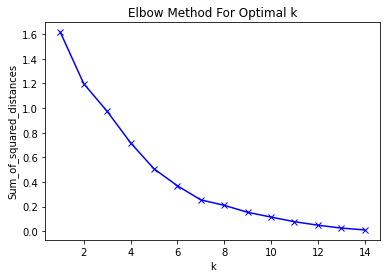

In [227]:
cph_grouped_clustering = cph_grouped.drop('Neighborhood', 1) #drop the column with the axis 1
x = cph_grouped_clustering
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k).fit(x)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

Here I chosen k=7 as the k value for the Kmeans

In [228]:
kclusters = 7
cph_grouped_clustering = cph_grouped.drop('Neighborhood', 1) #drop the column with the axis 1
x = cph_grouped_clustering

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(x) #cph_grouped_clustering without the neighborhood name

# check cluster labels generated for each row in the dataframe
kmeans.labels_ 

array([6, 4, 0, 0, 3, 1, 0, 0, 0, 5, 0, 0, 0, 2, 0], dtype=int32)

Merge the labels with the 'neighborhoods_venues_sorted' dataframe. Here a new column called 'Cluster Labels' is inserted into the dataframe

In [229]:
#add clusters
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
cph_merged = cph
# merge neighborhoods_venues_sorted with cph to add latitude/longitude for each neighborhood
cph_merged = cph_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
cph_merged.head() # check

,Neighborhood,Postal Codes,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Brønshøj,2700,55.70686961,12.48453613,6,Grocery Store,Department Store,Discount Store,Supermarket,Speakeasy,Gym / Fitness Center,Pizza Place,Playground,Dive Bar,Electronics Store
1,Dyssegård,2870,55.73280743,12.52674557,4,Restaurant,Gym / Fitness Center,Italian Restaurant,Ice Cream Shop,Food & Drink Shop,Flower Shop,Flea Market,Fish & Chips Shop,Fast Food Restaurant,Farm
2,Frederiksberg C,1874,55.67961226,12.54643622,0,Café,Bakery,Butcher,French Restaurant,Music Store,Pizza Place,Scandinavian Restaurant,Bookstore,Sushi Restaurant,Grocery Store
3,Frederiksberg,2000,55.68252254,12.51788731,0,Pizza Place,Coffee Shop,Grocery Store,Bar,Jewelry Store,Supermarket,Gym / Fitness Center,Gastropub,Furniture / Home Store,Middle Eastern Restaurant
4,Hellerup,2900,55.73356381,12.56079034,3,Platform,Italian Restaurant,Gastropub,Pizza Place,Café,Grocery Store,Fast Food Restaurant,Flower Shop,Flea Market,Fish & Chips Shop
5,Hvidovre,2650,55.63678283,12.47156818,1,Plaza,Grocery Store,Wine Bar,Fast Food Restaurant,Food Court,Food & Drink Shop,Flower Shop,Flea Market,Fish & Chips Shop,Farm
6,København K,1050,55.68060321,12.58567583,0,Restaurant,Scandinavian Restaurant,Coffee Shop,French Restaurant,Bar,Wine Bar,Cocktail Bar,Furniture / Home Store,Steakhouse,Café
7,København N,2200,55.69484852,12.55015575,0,Bakery,Wine Bar,Coffee Shop,Pizza Place,Bar,Thai Restaurant,Fast Food Restaurant,Beer Bar,Grocery Store,Scandinavian Restaurant
8,København NV,2400,55.70861537,12.52629945,0,Pizza Place,Food & Drink Shop,Sushi Restaurant,Gym / Fitness Center,Grocery Store,Bakery,Moving Target,Sports Bar,Scandinavian Restaurant,Supermarket
9,København S,2300,55.65110352,12.60292224,5,Farm,Comfort Food Restaurant,Badminton Court,Soccer Stadium,Fast Food Restaurant,Food Court,Food & Drink Shop,Flower Shop,Flea Market,Fish & Chips Shop


### Cluster Visualization

In [230]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(cph_merged['Latitude'], cph_merged['Longitude'], cph_merged['Neighborhood'], cph_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

###Cluster Analysis

Cluster 0

In [252]:
cluster0 = cph_merged.loc[cph_merged['Cluster Labels'] == 0]                           
cluster0

,Neighborhood,Postal Codes,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Frederiksberg C,1874,55.67961226,12.54643622,0,Café,Bakery,Butcher,French Restaurant,Music Store,Pizza Place,Scandinavian Restaurant,Bookstore,Sushi Restaurant,Grocery Store
3,Frederiksberg,2000,55.68252254,12.51788731,0,Pizza Place,Coffee Shop,Grocery Store,Bar,Jewelry Store,Supermarket,Gym / Fitness Center,Gastropub,Furniture / Home Store,Middle Eastern Restaurant
6,København K,1050,55.68060321,12.58567583,0,Restaurant,Scandinavian Restaurant,Coffee Shop,French Restaurant,Bar,Wine Bar,Cocktail Bar,Furniture / Home Store,Steakhouse,Café
7,København N,2200,55.69484852,12.55015575,0,Bakery,Wine Bar,Coffee Shop,Pizza Place,Bar,Thai Restaurant,Fast Food Restaurant,Beer Bar,Grocery Store,Scandinavian Restaurant
8,København NV,2400,55.70861537,12.52629945,0,Pizza Place,Food & Drink Shop,Sushi Restaurant,Gym / Fitness Center,Grocery Store,Bakery,Moving Target,Sports Bar,Scandinavian Restaurant,Supermarket
10,København SV,2450,55.64835460,12.53594049,0,Plaza,Pub,Office,Diner,Bus Station,Pizza Place,Hotel,Cosmetics Shop,Convenience Store,Electronics Store
11,København Ø,2100,55.70717133,12.57198501,0,Pizza Place,Bakery,Café,Playground,Gym / Fitness Center,Bagel Shop,Coffee Shop,Supermarket,Theater,Thai Restaurant
12,København V,1653,55.67201113,12.56115609,0,Café,Hotel,Scandinavian Restaurant,Cocktail Bar,Sushi Restaurant,Coffee Shop,Japanese Restaurant,Italian Restaurant,Restaurant,Breakfast Spot
14,Vanløse,2720,55.68955552,12.48688966,0,Grocery Store,Fast Food Restaurant,Bakery,Scandinavian Restaurant,Sushi Restaurant,Pizza Place,Convenience Store,Greek Restaurant,Gym / Fitness Center,Light Rail Station


Cluster 1

In [244]:
cluster1 = cph_merged.loc[cph_merged['Cluster Labels'] == 1, 
                                cph_merged.columns[[0] + list(range(5, cph_merged.shape[1]))]]                           
cluster1

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Hvidovre,Plaza,Grocery Store,Wine Bar,Fast Food Restaurant,Food Court,Food & Drink Shop,Flower Shop,Flea Market,Fish & Chips Shop,Farm


Cluster 2

In [246]:
cluster2 = cph_merged.loc[cph_merged['Cluster Labels'] == 2, 
                                cph_merged.columns[[0] + list(range(5, cph_merged.shape[1]))]]                           
cluster2

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
13,Valby,Indian Restaurant,Karaoke Bar,Playground,Pizza Place,Wine Bar,Farm,Food & Drink Shop,Flower Shop,Flea Market,Fish & Chips Shop


Cluster 3

In [247]:
cluster3 = cph_merged.loc[cph_merged['Cluster Labels'] == 3, 
                                cph_merged.columns[[0] + list(range(5, cph_merged.shape[1]))]]                           
cluster3

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Hellerup,Platform,Italian Restaurant,Gastropub,Pizza Place,Café,Grocery Store,Fast Food Restaurant,Flower Shop,Flea Market,Fish & Chips Shop


Cluster 4

In [248]:
cluster4 = cph_merged.loc[cph_merged['Cluster Labels'] == 4, 
                                cph_merged.columns[[0] + list(range(5, cph_merged.shape[1]))]]                           
cluster4

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Dyssegård,Restaurant,Gym / Fitness Center,Italian Restaurant,Ice Cream Shop,Food & Drink Shop,Flower Shop,Flea Market,Fish & Chips Shop,Fast Food Restaurant,Farm


Cluster 5

In [249]:
cluster5 = cph_merged.loc[cph_merged['Cluster Labels'] == 5, 
                                cph_merged.columns[[0] + list(range(5, cph_merged.shape[1]))]]                           
cluster5

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,København S,Farm,Comfort Food Restaurant,Badminton Court,Soccer Stadium,Fast Food Restaurant,Food Court,Food & Drink Shop,Flower Shop,Flea Market,Fish & Chips Shop


Cluster 6

In [250]:
cluster6 = cph_merged.loc[cph_merged['Cluster Labels'] == 6, 
                                cph_merged.columns[[0] + list(range(5, cph_merged.shape[1]))]]                           
cluster6

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Brønshøj,Grocery Store,Department Store,Discount Store,Supermarket,Speakeasy,Gym / Fitness Center,Pizza Place,Playground,Dive Bar,Electronics Store


# Tourist residential areas


In the previous section we saw that we have many neighborhoods that belong to the Cluster 0 which are defined as the 'Trendy and Going-out Areas' of the city. However, these neighborhoods are not small and whithin a given neighborhood there might be areas that are not so attractive. 

In order to find the most attractive areas to open a bar I have used a AirBNB listings dataset for the city of Copenhagen which is publicly avaliable for download at: https://tomslee.net/category/airbnb-data . The combination of these dataset with the information we got previously from the clusters can define where the Bar should be opened with much more location precision.



In [240]:
listings_url = 'https://raw.githubusercontent.com/rafabrnd/Coursera_Capstone/master/listings.csv' 
listings = pd.read_csv(listings_url)
listings.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,6983,Copenhagen 'N Livin',16774,Simon,nan,Nrrebro,55.68798000,12.54571000,Private room,373,2,168,2019-07-19,1.32000000,1,0
1,26057,Lovely house - most attractive area,109777,Kari,nan,Indre By,55.69163000,12.57459000,Entire home/apt,2397,3,50,2019-12-14,0.66000000,1,333
2,26473,City Centre Townhouse Sleeps 1-12 persons,112210,Oliver,nan,Indre By,55.67590000,12.57698000,Entire home/apt,3103,3,292,2020-02-21,2.56000000,2,81
3,29118,Best Location in Cool Istedgade,125230,Nana,nan,Vesterbro-Kongens Enghave,55.67069000,12.55430000,Entire home/apt,801,7,22,2019-08-02,0.19000000,1,26
4,29618,Artsy and familyfriendly home in lovely Copenhagen,127577,Simon And Anna,nan,sterbro,55.69375000,12.56945000,Entire home/apt,862,7,90,2017-06-03,0.77000000,1,0


Clean up the dataset. The only thing we need from this dataset is the latitude and the longitude values. 

Notes: Here I decided to use a map tile 'Stamen Toner' because Copenhagen have multiple water canals which makes its easier to locate the different areas when using a heatmap on top. 




In [242]:
#reduce the size of the dataframe
limit = 250
listings_filtered = listings.iloc[0:limit, :]

#define new variable with only the 'latitude' and 'longitude' features
listings_filtered = listings_filtered[['latitude','longitude']]
#remove any NaN values
listings_filtered = listings_filtered.dropna(axis=0)
#loop to make a list with the latitude and longitude (nested list)
listings_filtered = [[row['latitude'],row['longitude']] for index, row in listings_filtered.iterrows()]


#create map object
map_cph_airbnb = folium.Map(location = [latitude, longitude], zoom_start = 13, tiles='Stamen Toner')

#Heatmap
from folium import plugins
from folium.plugins import HeatMap

HeatMap(listings_filtered).add_to(map_cph_airbnb)

# Display the map
map_cph_airbnb

# Clusters & tourist residential areas

The following map shows an overlay of the Cluster0 (the neighborhoods that have more restaurants and bards) with the most popular toursit residential areas (where the tourists choose to stay)

This map shows that Neighborhoods such as 'Copenhagen N' and 'Copenhagen V' are the most attractive for tourists and represent the best candidates for the location of a new bar.

In [259]:
#Replace Cluster0 names with their English version; The current name letters are not supported by folium
namelist = ['Frederiksberg C','Frederiksberg','Copenhagen C','Copenhagen N','Copenhagen NV','Copenhagen SV',
            'Copenhagen O','Copenhagen V','Vanlose']
cluster0['Neighborhood'] = namelist

# add pop-up text to each marker on the map
latitudes = list(cluster0['Latitude'])
longitudes = list(cluster0['Longitude'])
labels = list(cluster0['Neighborhood'])

for lat, lng, label in zip(latitudes, longitudes, labels):
    folium.Marker([lat, lng], popup=label,icon=folium.Icon(icon='cloud', color='darkblue')).add_to(map_cph_airbnb)    

map_cph_airbnb

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
